# Alanine Multistate
## Example Simulation

This uses the state definition from [1]. 6 states named A,B,C,D,E and F

[1] W.-N. Du, K. A. Marino, and P. G. Bolhuis, “Multiple state transition interface sampling of alanine dipeptide in explicit solvent,” J. Chem. Phys., vol. 135, no. 14, p. 145102, 2011.

Import Modules

In [56]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
import math
import random

import openpathsampling as paths
import openpathsampling.storage as st
import simtk.unit as u

from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit

from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

In [57]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Radians to Degree conversion

In [58]:
degrees = 180/3.14159 # psi reports in radians; I think in degrees

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

Set the regular simulation parameters

In [4]:
template = paths.tools.snapshot_from_pdb("../data/Alanine_solvated.pdb")

In [60]:
template.box_vectors

Quantity(value=array([[ 2.60630012,  0.        ,  0.        ],
       [ 0.        ,  2.60630012,  0.        ],
       [ 0.        ,  0.        ,  2.60630012]], dtype=float32), unit=nanometer)

In [61]:
template.topology.n_atoms

1651

In [5]:
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')

omm_topology = paths.tools.to_openmm_topology(template)

system = forcefield.createSystem(omm_topology, nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds, rigidWater=True, 
    ewaldErrorTolerance=0.0005)
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

platform = mm.Platform.getPlatformByName('OpenCL')
properties = {'OpenCLPrecision': 'mixed'}

In [6]:
engine = paths.OpenMMEngine(
    template, 
    system, 
    integrator, 
    properties=properties
)
engine.name = 'default'

Set a high temperature simulation for exploration.

In [7]:
integrator_high = mm.LangevinIntegrator(1000*unit.kelvin, 1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator_high.setConstraintTolerance(0.00001)

In [8]:
engine_high = engine.from_new_options(integrator=integrator_high)
engine_high.name = 'high'

In [9]:
paths.EngineMover.engine = engine

In [10]:
storage = st.Storage("ala.nc", mode='w', template=template)

In [11]:
storage.save(engine)
storage.save(engine_high)

And save the storage in a separate variable for convenience

In [12]:
platform = engine.simulation.context.getPlatform()

In [13]:
print platform.getName()

OpenCL


Equilibrate

In [14]:
engine.current_snapshot = engine.template
engine.minimize()
engine_high.current_snapshot = engine.template
engine_high.minimize()

Save equilibrated snapshots

In [15]:
initial_snapshot_low = engine.current_snapshot
initial_snapshot_high = engine_high.current_snapshot

In [16]:
storage.save(engine.current_snapshot);
storage.save(engine_high.current_snapshot);

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [17]:
psi_atoms = [6,8,14,16]
psi = paths.CV_MDTraj_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = paths.CV_MDTraj_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

storage.save([psi, phi]);

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

Define state as in [1]

In [18]:
state_letter = {
    'A' : 'A',
    'B' : 'B',
    'C' : 'C',
    'D' : 'D',
    'E' : 'E',
    'F' : 'F',
    'alpha' : u'α',
    'beta' : u'β'
}

In [19]:
state_centers = {
    'A' : [-150, 150], 
    'B' : [-70, 135], 
    'C' : [-150, -65], 
    'D' : [-70, -50], 
    'E' : [50, -100], 
    'F' : [40, 65]
}

In [20]:
interface_levels = {
    'A' : [10, 20, 45, 65, 80],
    'B' : [10, 20, 45, 65, 75],
    'C' : [10, 20, 45, 60],
    'D' : [10, 20, 45, 60],
    'E' : [10, 20, 45, 65, 80],
    'F' : [10, 20, 45, 65, 80],
    'alpha' : [10, 20, 45, 55, 65, 75],
    'beta' : [10, 20, 40, 45, 50, 60],    
}

Define a function that defines a distance in periodic $\phi,\psi$-space.

In [21]:
def circle_degree(snapshot, center, phi, psi):
    import math
    degrees = 180/3.14159    
    psi_deg = psi(snapshot) * degrees
    phi_deg = phi(snapshot) * degrees
    return math.sqrt(
            ( min( phi_deg - center[0], 360 - phi_deg + center[0])**2 + 
              min( psi_deg - center[1], 360 - psi_deg + center[1])**2)
             )

In [22]:
op_state = dict()
for state in state_centers:
    op = paths.CV_Function(
        name = 'op' + state,
        f=circle_degree,
        center=state_centers[state],
        psi=psi,
        phi=phi
    )
    op_state[state] = op

In [23]:
storage.save(op_state.values())

Create `Volume` objects for all states

In [24]:
vol_state = dict()
for state in op_state:
    vol_state[state] = paths.CVRangeVolume(op_state[state], lambda_max=10.0)
    
vol_state['alpha'] = vol_state['A'] & vol_state['B']
vol_state['beta'] = vol_state['C'] & vol_state['D']

Create Interfaces

In [25]:
interface_list = {}
for state in interface_levels:
    levels = interface_levels[state]
    interface_list[state] = [None] * len(levels)
    for idx, level in enumerate(levels):
        if state == 'alpha':
            interface_list[state][idx] = \
                paths.CVRangeVolume(op_state['A'], lambda_max=level) | \
                paths.CVRangeVolume(op_state['B'], lambda_max=level)
        elif state == 'beta':
            interface_list[state][idx] = \
                paths.CVRangeVolume(op_state['C'], lambda_max=level) | \
                paths.CVRangeVolume(op_state['D'], lambda_max=level)
        else:
            interface_list[state][idx] = \
                paths.CVRangeVolume(op_state[state], lambda_max=level)

In [26]:
def get_state(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        if interface_list[name][-1](snapshot):
            return name

    return 'X'

def get_core(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        if interface_list[name][0](snapshot):
            return name

    return 'X'

def get_interface(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        for idx, interface in enumerate(interface_list[name]):
            if interface(snapshot):
                return name, idx

    return 'X', 0

In [27]:
def state_information(snapshot):
    for name in ['A', 'B', 'C', 'D', 'E', 'F']:
        op = op_state[name]
        print '%s: %7.2f' % (name, op(snapshot)),
        for idx, interface in enumerate(interface_list[name]):
            if interface(snapshot):
                print '+',
                current_state = name
            else:
                print '-',

        print    

    print 'The initial configuration is in state', current_state

In [28]:
state_information(initial_snapshot_high)
state_information(initial_snapshot_low)

A:  212.17 - - - - -
B:  180.93 - - - - -
C:   83.62 - - - -
D:    4.31 + + + +
E:  130.33 - - - - -
F:  155.23 - - - - -
The initial configuration is in state D
A:  211.68 - - - - -
B:  179.17 - - - - -
C:   86.96 - - - -
D:    7.36 + + + +
E:  128.39 - - - - -
F:  151.84 - - - - -
The initial configuration is in state D


In [29]:
paths.EngineMover.engine = engine_high

First we need to get at least one conformation in each state. Since this problem is realated to the problem of finding initial trajectories we do both at the same time.

In [30]:
stA, stB, stC, stD, stE, stF, stAlpha, stBeta = [
    interface_list[state][0] for state in ['A','B','C','D','E','F','alpha','beta']
]

In [31]:
stAll = stA | stB | stC | stD | stE | stF

Minimize until we reach one core

In [32]:
reach_core = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(stAlpha | stBeta)),
        paths.LengthEnsemble(1) & paths.AllOutXEnsemble(stAlpha | stBeta)
    ])

In [33]:
init_traj = engine_high.generate(storage.template, [reach_core.can_append])

In [34]:
current_snapshot = init_traj[-1]

In [35]:
state_information(current_snapshot)

A:  212.13 - - - - -
B:  179.41 - - - - -
C:   87.51 - - - -
D:    7.57 + + + +
E:  127.73 - - - - -
F:  151.57 - - - - -
The initial configuration is in state D


In [36]:
core2core = paths.SequentialEnsemble(
    [
        paths.OptionalEnsemble(paths.AllInXEnsemble(stAll)),
        paths.AllOutXEnsemble(stAll),
        paths.SingleFrameEnsemble(
            paths.AllInXEnsemble(stAll)
        )
    ]
)

In [37]:
visit_all = reduce(
    lambda x,y: x & y, 
    [
        paths.PartInXEnsemble(interfaces[0])
        for state, interfaces in interface_list.iteritems()
    ],
    paths.FullEnsemble()
)

In [38]:
def cvlines(data, *cvs):
    all_points = [cv(data) for cv in cvs]
    ret = []
    first = 0
    for d in range(1,len(data)):
        flip = False
        for c in range(len(cvs)):
            if periodicflip(all_points[c][d], all_points[c][d-1], math.pi):
                flip = True
                                
        if flip:
            ret.append([all_points[c][first:d] for c in range(len(cvs))])
            first = d

    ret.append([all_points[c][first:d+1] for c in range(len(cvs))])    
            
    return ret
            
    
def periodicflip(val1, val2, period):
    return (period**2 - (val1 - val2)**2) < (val1 - val2)**2

In [39]:
%config InlineBackend.figure_format='retina'

def plot_main():
    plt.figure(figsize=(8, 8))
    rect = plt.Rectangle((-180,-180),360,360, facecolor="none", edgecolor="none")    
    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    
    
    centers = state_centers.values()

    plt.plot([x[0] for x in centers], [x[1] for x in centers], 'ko')

    fig = plt.gcf()

    for level in range(100,0,-1):
        for col in [True, False]:
            for name, center in state_centers.iteritems():
                if level == 1:
                    plt.annotate(name, xy=center, xytext=(center[0]+10 + 1, center[1] - 1), fontsize=20, color='k')
                    plt.annotate(name, xy=center, xytext=(center[0]+10, center[1]), fontsize=20, color='w')

                if level in interface_levels[name]:
                    for xp in [-1, 0, 1]:
                        for yp in [-1, 0, 1]:
                            if col:
                                circle = plt.Circle((center[0] + xp * 360, center[1] + yp * 360), level, color='w')
                                fig.gca().add_artist(circle)
                            else:
                                l = 1.0 * level / 100
                                circle = plt.Circle(
                                    (center[0] + xp * 360, center[1] + yp * 360), 
                                    level - 1, 
                                    color=(l + 0.0,l + 0.2, 0.6)
                                )
                                fig.gca().add_artist(circle)

                        # circle.set_clip_path(rect)

    plt.axis('equal')
    plt.axis((-180,180,-180,180))
                    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    

In [40]:
def plot_traj(traj):    
    angles = cvlines(traj, phi, psi)

    for angle in angles:
        plt.plot(degrees * np.array(angle[0])[:], degrees * np.array(angle[1])[:], 'ko', linewidth=0.5)
        plt.plot(degrees * np.array(angle[0])[:], degrees * np.array(angle[1])[:], 'k-', linewidth=0.5)

Set initial store

In [41]:
tt = init_traj
found_states = set()
missing_states = set([state for state in 'ABCDEF'])
data = np.array([[op_state[state](frame) for state in 'ABCDEF'] for frame in tt])
found_states.update([state for state in missing_states if any(map(interface_list[state][0], tt))])
missing_states = missing_states - found_states
storage.save(tt)

In [44]:
chunksize = 5
first = True
while len(missing_states) > 0 or first:
    first = False
    while True:
        tt = engine_high.generate_forward(tt[-1], core2core)
        storage.save(tt)
        data = np.array([[op_state[state](frame) for state in 'ABCDEF'] for frame in tt])
        found_states.update([state for state in missing_states if sum(map(interface_list[state][0], tt)) > 0])
        missing_states = missing_states - found_states 
        print '%4d  %s < %4d > %s miss %s' % (
            len(storage.trajectories), 
            get_state(tt[0]), 
            len(tt) - 2, 
            get_state(tt[-1]), 
            ''.join(missing_states)
        )

        if len(storage.trajectories) % chunksize == 0:
            break

   4  D <   18 > D miss ACBEF
   5  D <   28 > C miss ABEF
   6  C <    7 > D miss ABEF
   7  D <    2 > D miss ABEF
   8  D <   41 > D miss ABEF
   9  D <   99 > A miss BEF
  10  A <    1 > A miss BEF
  11  A <   85 > C miss BEF
  12  C <    4 > C miss BEF
  13  C <   25 > D miss BEF
  14  D <   59 > A miss EF
  15  A <   38 > B miss EF
  16  B <   10 > A miss EF
  17  A <   71 > A miss EF
  18  A <    2 > A miss EF
  19  A <    8 > A miss EF
  20  A <   10 > A miss EF
  21  A <    1 > A miss EF
  22  A <    5 > A miss EF
  23  A <   70 > A miss EF
  24  A <    2 > A miss EF
  25  A <   19 > A miss EF
  26  A <    5 > B miss EF
  27  B <    8 > B miss EF
  28  B <   28 > B miss EF
  29  B <   21 > B miss EF
  30  B <    2 > B miss EF
  31  B <    2 > B miss EF
  32  B <    8 > B miss EF
  33  B <   23 > A miss EF
  34  A <   29 > B miss EF
  35  B <    2 > B miss EF
  36  B <   41 > F miss E
  37  F <   43 > A miss E
  38  A <    2 > B miss E
  39  B <   18 > B miss E
  40  B <    3 >

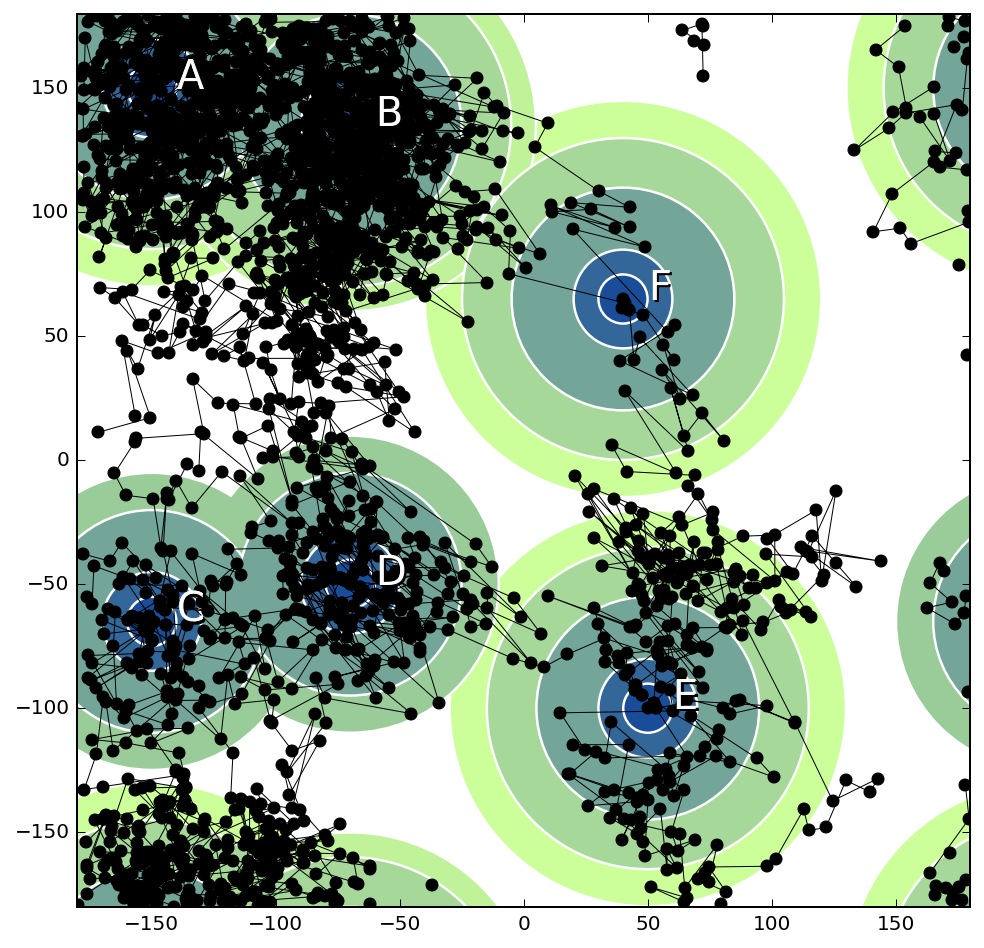

In [45]:
plot_main()
for tr in storage.trajectories:
    plot_traj(tr)

In [47]:
small_state_list = ['A','B','C','D','E','F']

In [48]:
mstis = paths.MSTISNetwork([
    (
        interface_list[state][0],
        interface_list[state][1:],
        op_state[state]
    ) for state in small_state_list

])

In [49]:
storage.save(mstis)

In [50]:
initial_bootstrap = dict()

In [51]:
for state in small_state_list:
    print 'Bootstrapping state', state
    if state not in initial_bootstrap:
        from_state = interface_list[state][0]
        initials = [snap for snap in storage.snapshots if from_state(snap)]
        bootstrapA = paths.FullBootstrapping(
            transition=mstis.from_state[from_state],
            snapshot=random.choice(initials),
            engine=engine,
            extra_interfaces=[interface_list[state][-1]],
            initial_max_length=20      
        )
        initial_bootstrap[state] = bootstrapA.run(max_ensemble_rounds=50)

DONE! Completed Bootstrapping cycle step 7 in ensemble 4/4 .



In [52]:
total_sample_set = paths.SampleSet.relabel_replicas_per_ensemble(
    initial_bootstrap.values()
)

In [53]:
storage.save(total_sample_set)
storage.sync_all()

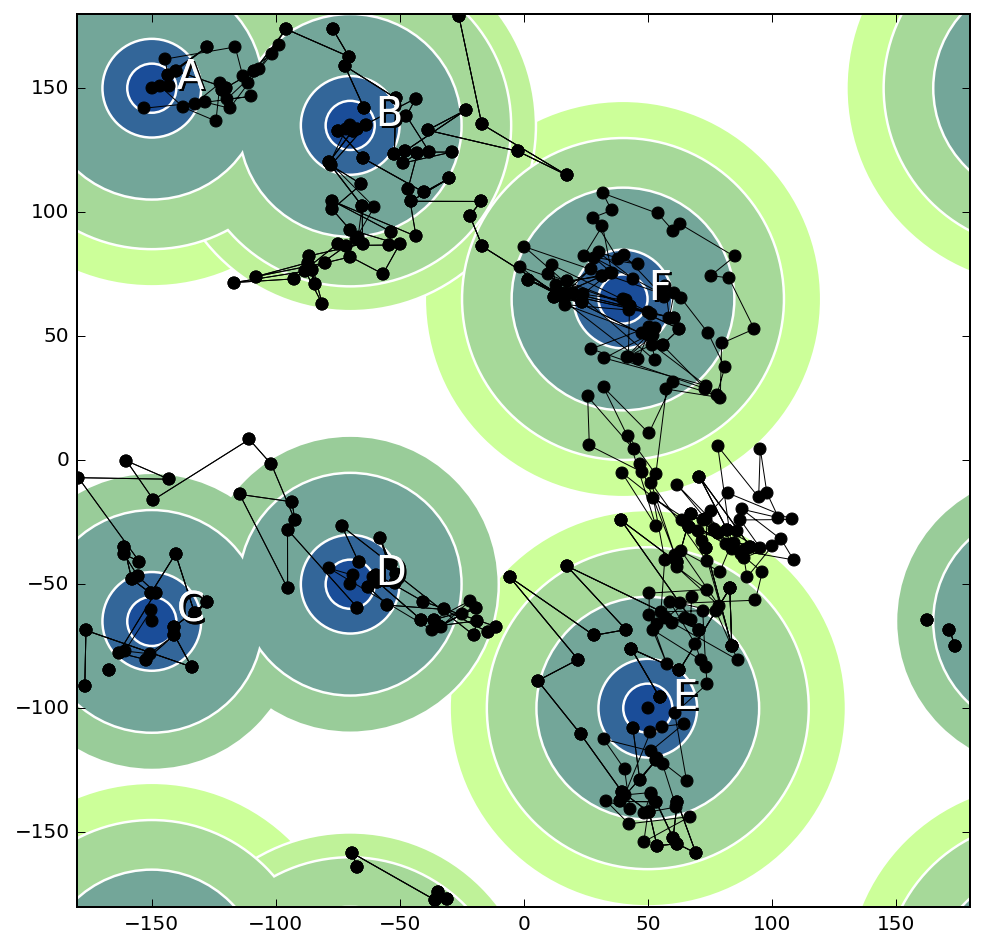

In [54]:
plot_main()
for s in total_sample_set:
    plot_traj(s.trajectory)

In [55]:
storage.close()